# Example-17: Line (element)

In [1]:
# In this example line usage is illustrated

In [2]:
from pathlib import Path
from os import system

from pprint import pprint

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

import torch

from model.library.drift import Drift
from model.library.quadrupole import Quadrupole
from model.library.sextupole import Sextupole
from model.library.dipole import Dipole
from model.library.line import Line

In [3]:
# Define unique elements

QF = Quadrupole('QF', 0.5, +0.25)
QD = Quadrupole('QD', 0.5, -0.20)
SF = Sextupole('SF', 0.25)
SD = Sextupole('SD', 0.25)
DR = Drift('DR', 0.25)
BM = Dipole('BM', 3.50, torch.pi/8.0)

In [4]:
# Define a line
# With propagate flag, values for other flags will be propagated to all root elements (but not to lines!)

FODO = Line('FODO', 
            [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], 
            propagate=True, 
            dp=0.0, 
            exact=False, 
            output=False,
            matrix = False)

In [5]:
# Similar to elements, lines have to variants of call method

# 1) without deviation variables

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
print(FODO(state))

# 2) without deviation variables (defaut dictionary)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
print(FODO(state, data=FODO.data()))

# In both cases, it is possible to apply alignments errors using alignment flag
# Alignment errors can be applied to elements

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Values of deviation variables can be passed only to unique elements

pprint(FODO.data(alignment=False))

{'BM': {'dl': tensor(0., dtype=torch.float64),
        'dp': tensor(0., dtype=torch.float64),
        'dw': tensor(0., dtype=torch.float64),
        'e1': tensor(0., dtype=torch.float64),
        'e2': tensor(0., dtype=torch.float64),
        'kn': tensor(0., dtype=torch.float64),
        'ks': tensor(0., dtype=torch.float64),
        'mo': tensor(0., dtype=torch.float64),
        'ms': tensor(0., dtype=torch.float64)},
 'DR': {'dl': tensor(0., dtype=torch.float64),
        'dp': tensor(0., dtype=torch.float64)},
 'QD': {'dl': tensor(0., dtype=torch.float64),
        'dp': tensor(0., dtype=torch.float64),
        'kn': tensor(0., dtype=torch.float64),
        'ks': tensor(0., dtype=torch.float64)},
 'QF': {'dl': tensor(0., dtype=torch.float64),
        'dp': tensor(0., dtype=torch.float64),
        'kn': tensor(0., dtype=torch.float64),
        'ks': tensor(0., dtype=torch.float64)},
 'SD': {'dl': tensor(0., dtype=torch.float64),
        'dp': tensor(0., dtype=torch.float64),
        '

In [7]:
# Mapping over a set of initial conditions

state = 1.0E-3*torch.randn((512, 4), dtype=FODO.dtype, device=FODO.device)
print(torch.vmap(FODO)(state).shape)

torch.Size([512, 4])


In [8]:
# Mapping over a set of initial conditions and parameters

state = 1.0E-3*torch.randn((512, 4), dtype=FODO.dtype, device=FODO.device)
dknqf = 1.0E-3*torch.randn(512, dtype=FODO.dtype, device=FODO.device)

def wrapper(state, dknqf):
    data = FODO.data()
    data['QF']['kn'] = dknqf
    return FODO(state, data=data)

print(torch.vmap(wrapper)(state, dknqf).shape)

torch.Size([512, 4])


In [9]:
# Differentiability (state)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

print(torch.func.jacrev(FODO)(state))

tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)


In [10]:
# Differentiability (parameter)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

dknqf = torch.tensor(0.0, dtype=torch.float64)

def wrapper(dknqf):
    data = FODO.data()
    data['QF']['kn'] = dknqf
    return FODO(state, data=data)

print(torch.func.jacrev(wrapper)(dknqf))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [11]:
# Differentiability (composed)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

dknqf = torch.tensor(0.0, dtype=torch.float64)

def wrapper(dknqf):
    data = FODO.data()
    data['QF']['kn'] = dknqf
    return torch.func.jacrev(lambda state, data: FODO(state, data=data))(state, data)

print(wrapper(dknqf))
print(torch.func.jacrev(wrapper)(dknqf))

tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)
tensor([[-7.5649, -3.8172,  0.0000,  0.0000],
        [ 0.4176, -7.5649,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.7423,  1.3262],
        [ 0.0000,  0.0000,  0.5426,  2.7423]], dtype=torch.float64)


In [12]:
%%time

# Tracking

# Note, in general tracking is slow
# This is especially the case for exact integration of elements with large number of slices

qx = torch.linspace(0.0, 0.01, 16, dtype=torch.float64)
px = torch.zeros_like(qx)
qy = torch.zeros_like(qx)
py = torch.zeros_like(qx)

state = torch.stack([qx, px, qy, py]).T
orbit = []

for _ in range(2**10):
    state = torch.vmap(FODO)(state)
    orbit.append(state)

qx, px, *_ = torch.stack(orbit).swapaxes(0, -1)

CPU times: user 8.17 s, sys: 2.67 ms, total: 8.18 s
Wall time: 8.18 s


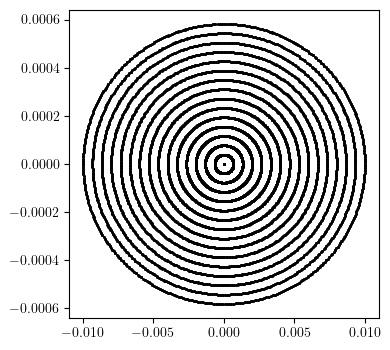

In [13]:
# Plot trajectories

plt.figure(figsize=(4, 4))
plt.scatter(qx.cpu().numpy(), px.cpu().numpy(), s=1, color='black')
plt.show()

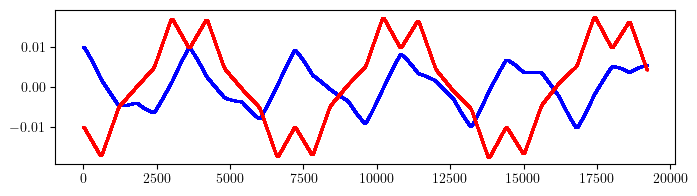

CPU times: user 14 s, sys: 159 ms, total: 14.2 s
Wall time: 14 s


In [14]:
%%time

# Output can be collected at each integration step
# Note, container is overwritten at each call

FODO.ns = 0.01
FODO.output = True

state = torch.tensor([+0.01, 0.0, -0.01, 0.0], dtype=torch.float64)
orbit = []
for _ in range(16):
    state = FODO(state)
    orbit.append(FODO.container_output)
qx, _, qy, _  = torch.vstack(orbit).T

plt.figure(figsize=(8, 2))
plt.scatter(range(len(qx)), qx.cpu().numpy(), s=1, color='blue')
plt.scatter(range(len(qy)), qy.cpu().numpy(), s=1, color='red')
plt.show()

In [15]:
%%time

# Functions can be compiled, but note that dynamo unrolls loops completely (torch 2.4)
# This leads to very long compilation times

FODO.ns = 1

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
table = 1.0E-3*torch.randn((512, 4), dtype=FODO.dtype, device=FODO.device)

fodo = torch.compile(FODO)
fodo(state)

CPU times: user 17.8 s, sys: 5.1 s, total: 22.9 s
Wall time: 24.8 s


tensor([0., 0., 0., 0.], dtype=torch.float64)

In [16]:
%%timeit

FODO(state)

4.71 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit

fodo(state)

458 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
%%timeit

_ = torch.vmap(FODO)(table)

8.5 ms ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit

_ = torch.vmap(fodo)(table)

8.89 ms ± 514 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
# Note, compositional operations (map or jacobian seems to break/ignore compiled version)

In [21]:
# name (property)
# This property can be used to get/set line name

FODO.name

'FODO'

In [22]:
# sequence (property)
# Contains ordered sequence of elements
# Elements can be added or removed from it

len(FODO.sequence)

18

In [23]:
# unique (property)
# name: (type, length, angle) data for all unique elements

pprint(FODO.unique)

{'BM': ('Dipole',
        tensor(3.5000, dtype=torch.float64),
        tensor(0.3927, dtype=torch.float64)),
 'DR': ('Drift',
        tensor(0.2500, dtype=torch.float64),
        tensor(0., dtype=torch.float64)),
 'QD': ('Quadrupole',
        tensor(0.5000, dtype=torch.float64),
        tensor(0., dtype=torch.float64)),
 'QF': ('Quadrupole',
        tensor(0.5000, dtype=torch.float64),
        tensor(0., dtype=torch.float64)),
 'SD': ('Sextupole',
        tensor(0.2500, dtype=torch.float64),
        tensor(0., dtype=torch.float64)),
 'SF': ('Sextupole',
        tensor(0.2500, dtype=torch.float64),
        tensor(0., dtype=torch.float64))}


In [24]:
# length (property)

FODO.length

tensor(12., dtype=torch.float64)

In [25]:
# angle (property)

FODO.angle

tensor(0.7854, dtype=torch.float64)

In [26]:
# ns (property)
# This property can be used to get/set number of integration steps to unique elements

# Set value integration steps to all elements

FODO.ns = 10
print(FODO.ns)

# Set ceil(element.length/value) integration steps to each element

FODO.ns = 0.1
print(FODO.ns)

# Set by name or type

FODO.ns = (('DR', 1), ('Sextupole', 0.01))
print(FODO.ns)

{'QF': 10, 'DR': 10, 'SF': 10, 'BM': 10, 'SD': 10, 'QD': 10}
{'QF': 5, 'DR': 3, 'SF': 3, 'BM': 35, 'SD': 3, 'QD': 5}
{'QF': 5, 'DR': 1, 'SF': 25, 'BM': 35, 'SD': 25, 'QD': 5}


In [27]:
# order (property)
# This property can be used to get/set integration order to unique elements

# Set value integration steps to all elements

FODO.order = 0
print(FODO.order)

# Set by name or type

FODO.order = (('BM', 1), ('Sextupole', 1))
print(FODO.order)

{'QF': 0, 'DR': 0, 'SF': 0, 'BM': 0, 'SD': 0, 'QD': 0}
{'QF': 0, 'DR': 0, 'SF': 1, 'BM': 1, 'SD': 1, 'QD': 0}


In [28]:
# Nested lines

FODO = Line('FODO', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)
RING = Line('RING', 8*[FODO], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

RING.ns = 1
print(RING.ns)

RING.order = 0
print(RING.order)

# Note, sublines are not flattened

print(len(RING.sequence))

{'QF': 1, 'DR': 1, 'SF': 1, 'BM': 1, 'SD': 1, 'QD': 1}
{'QF': 0, 'DR': 0, 'SF': 0, 'BM': 0, 'SD': 0, 'QD': 0}
8


In [29]:
# Tracking, mapping and differentiation is similar to flat lines

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
RING(state)

tensor([0., 0., 0., 0.], dtype=torch.float64)

In [30]:
# Deviation table contains unique lines with unique elements (unique by names)

pprint(RING.data(alignment=False))

{'FODO': {'BM': {'dl': tensor(0., dtype=torch.float64),
                 'dp': tensor(0., dtype=torch.float64),
                 'dw': tensor(0., dtype=torch.float64),
                 'e1': tensor(0., dtype=torch.float64),
                 'e2': tensor(0., dtype=torch.float64),
                 'kn': tensor(0., dtype=torch.float64),
                 'ks': tensor(0., dtype=torch.float64),
                 'mo': tensor(0., dtype=torch.float64),
                 'ms': tensor(0., dtype=torch.float64)},
          'DR': {'dl': tensor(0., dtype=torch.float64),
                 'dp': tensor(0., dtype=torch.float64)},
          'QD': {'dl': tensor(0., dtype=torch.float64),
                 'dp': tensor(0., dtype=torch.float64),
                 'kn': tensor(0., dtype=torch.float64),
                 'ks': tensor(0., dtype=torch.float64)},
          'QF': {'dl': tensor(0., dtype=torch.float64),
                 'dp': tensor(0., dtype=torch.float64),
                 'kn': tensor(0., dtype=torch

In [31]:
# If this can be used to pass different values of deviation variables to unique elements
# But values should match for consistent differentiation

LA = Line('LA', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)
LB = Line('LB', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

RING = Line('RING', [LA, LB], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

state = torch.tensor([0.01, 0.0, 0.01, 0.0], dtype=torch.float64)

kn = torch.tensor(0.01, dtype=torch.float64)

data = RING.data()

data['LA']['QF']['kn'] = kn
data['LB']['QF']['kn'] = kn

print(RING(state, data=data))

kna = torch.tensor(+0.01, dtype=torch.float64)
knb = torch.tensor(-0.01, dtype=torch.float64)

data['LA']['QF']['kn'] = kna
data['LB']['QF']['kn'] = knb

print(RING(state, data=data))

tensor([-0.0047,  0.0005, -0.0045, -0.0014], dtype=torch.float64)
tensor([-0.0055,  0.0005, -0.0048, -0.0014], dtype=torch.float64)


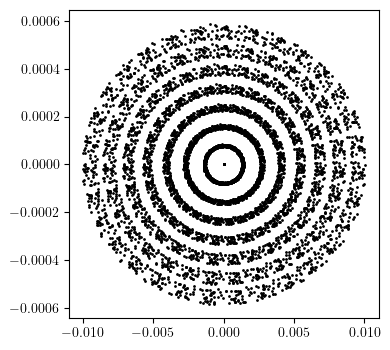

In [32]:
# Modulation

FODO = Line('FODO', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

dkf = 1.0E-3*torch.randn(2**10, dtype=torch.float64)
dkd = 1.0E-3*torch.randn(2**10, dtype=torch.float64)

qx = torch.linspace(0.0, 0.01, 8, dtype=torch.float64)
px = torch.zeros_like(qx)
qy = torch.zeros_like(qx)
py = torch.zeros_like(qx)

state = torch.stack([qx, px, qy, py]).T
orbit = []

data = FODO.data()

for i in range(2**10):
    data['QF']['kn'] = dkf[i]
    data['QD']['kn'] = dkd[i]
    state = torch.vmap(lambda state: FODO(state, data=data))(state)
    orbit.append(state)

qx, px, *_ = torch.stack(orbit).swapaxes(0, -1)

plt.figure(figsize=(4, 4))
plt.scatter(qx.cpu().numpy(), px.cpu().numpy(), s=1, color='black')
plt.show()

tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)

tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)



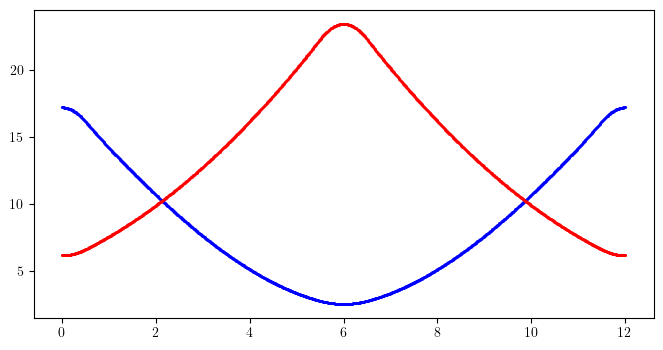

In [33]:
# Matrix output and twiss parameters

from twiss import twiss
from twiss import propagate
from twiss import wolski_to_cs

QF = Quadrupole('QF', 0.5, +0.25)
QD = Quadrupole('QD', 0.5, -0.20)
SF = Sextupole('SF', 0.25)
SD = Sextupole('SD', 0.25)
DR = Drift('DR', 0.25)
BM = Dipole('BM', 3.50, torch.pi/8.0)

FODO = Line('FODO', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, matrix=True)
FODO.ns = 0.01

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

print(torch.func.jacrev(FODO)(state))
print()

out, *ms = FODO.container_matrix
for m in ms:
   out = m @ out
print(out)
print()

*_, w = twiss(out)
ws = [w]

for m in FODO.container_matrix:
    w = propagate(w, m)
    ws.append(w)

ws = torch.stack(ws)

_, bx, _, by = torch.vmap(wolski_to_cs)(ws).T

s = torch.linspace(0.0, 12.0, len(bx), dtype=torch.float64)

plt.figure(figsize=(8, 4))
plt.scatter(s.cpu().numpy(), bx.cpu().numpy(), s=1, color='blue')
plt.scatter(s.cpu().numpy(), by.cpu().numpy(), s=1, color='red')
plt.show()

In [34]:
# More line properties

# Define simple FODO based lattice using nested lines

DR = Drift('DR', 0.25)
BM = Dipole('BM', 3.50, torch.pi/4.0)

QF_A = Quadrupole('QF_A', 0.5, +0.20)
QD_A = Quadrupole('QD_A', 0.5, -0.19)
QF_B = Quadrupole('QF_B', 0.5, +0.20)
QD_B = Quadrupole('QD_B', 0.5, -0.19)
QF_C = Quadrupole('QF_C', 0.5, +0.20)
QD_C = Quadrupole('QD_C', 0.5, -0.19)
QF_D = Quadrupole('QF_D', 0.5, +0.20)
QD_D = Quadrupole('QD_D', 0.5, -0.19)

SF_A = Sextupole('SF_A', 0.25, 0.00)
SD_A = Sextupole('SD_A', 0.25, 0.00)
SF_B = Sextupole('SF_B', 0.25, 0.00)
SD_B = Sextupole('SD_B', 0.25, 0.00)
SF_C = Sextupole('SF_C', 0.25, 0.00)
SD_C = Sextupole('SD_C', 0.25, 0.00)
SF_D = Sextupole('SF_D', 0.25, 0.00)
SD_D = Sextupole('SD_D', 0.25, 0.00)

FODO_A = Line('FODO_A', [QF_A, DR, SF_A, DR, BM, DR, SD_A, DR, QD_A, QD_A, DR, SD_A, DR, BM, DR, SF_A, DR, QF_A], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_B = Line('FODO_B', [QF_B, DR, SF_B, DR, BM, DR, SD_B, DR, QD_B, QD_B, DR, SD_B, DR, BM, DR, SF_B, DR, QF_B], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_C = Line('FODO_C', [QF_C, DR, SF_C, DR, BM, DR, SD_C, DR, QD_C, QD_C, DR, SD_C, DR, BM, DR, SF_C, DR, QF_C], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_D = Line('FODO_D', [QF_D, DR, SF_D, DR, BM, DR, SD_D, DR, QD_D, QD_D, DR, SD_D, DR, BM, DR, SF_D, DR, QF_D], propagate=True, dp=0.0, exact=False, output=False, matrix=False)

RING = Line('RING', [FODO_A, FODO_B, FODO_C, FODO_D], propagate=True, dp=0.0, exact=False, output=False, matrix=False)

In [35]:
# Name and names

print(FODO_A.name)
print(FODO_A.names)
print()

print(RING.name)
print(RING.names)
print()

FODO_A
['QF_A', 'DR', 'SF_A', 'DR', 'BM', 'DR', 'SD_A', 'DR', 'QD_A', 'QD_A', 'DR', 'SD_A', 'DR', 'BM', 'DR', 'SF_A', 'DR', 'QF_A']

RING
['FODO_A', 'FODO_B', 'FODO_C', 'FODO_D']



In [36]:
# Scan (recurcivly traverse lattice and yeild elements with matching attribute)

# All elements, since all elements have a name

print(len([*FODO_A.scan('name')]))
print(len([*RING.scan('name')]))

# All dipoles

print(len([*FODO_A.scan('angle')]))
print(len([*RING.scan('angle')]))

18
72
2
8


In [37]:
# Flatten

print(len(RING))

RING.flatten()
print(len(RING))

4
72


In [38]:
# First positon of an element

print(FODO_A.position('BM'))
print(FODO_A.names)

4
['QF_A', 'DR', 'SF_A', 'DR', 'BM', 'DR', 'SD_A', 'DR', 'QD_A', 'QD_A', 'DR', 'SD_A', 'DR', 'BM', 'DR', 'SF_A', 'DR', 'QF_A']


In [39]:
# Get first element

print(FODO_A.start)
print(FODO_A.names)

QF_A
['QF_A', 'DR', 'SF_A', 'DR', 'BM', 'DR', 'SD_A', 'DR', 'QD_A', 'QD_A', 'DR', 'SD_A', 'DR', 'BM', 'DR', 'SF_A', 'DR', 'QF_A']


In [40]:
# Set first element (rotate sequence)
# Note, first mathced occuranve is used

FODO_A.start = 'BM'
print(FODO_A.names)

['BM', 'DR', 'SD_A', 'DR', 'QD_A', 'QD_A', 'DR', 'SD_A', 'DR', 'BM', 'DR', 'SF_A', 'DR', 'QF_A', 'QF_A', 'DR', 'SF_A', 'DR']


In [41]:
# Itemize (list of all elements with matching kind)

print(RING.itemize('Sextupole'))

['SF_A', 'SD_A', 'SF_B', 'SD_B', 'SF_C', 'SD_C', 'SF_D', 'SD_D']


In [42]:
# Number of first level elements/lines

print(len(RING))

72


In [43]:
# Get by index or name (first matched)

print(FODO_B[1])
print(FODO_B['DR'])

Drift(name="DR", length=0.25, dp=0.0, exact=False, ns=1, order=0)
Drift(name="DR", length=0.25, dp=0.0, exact=False, ns=1, order=0)


In [44]:
# Set by index or name (first matched)

print(FODO_B.names)

FODO_B['SF_B'] = FODO_B['DR']
print(FODO_B.names)

FODO_B['SF_B'] = FODO_B['DR']
print(FODO_B.names)

['QF_B', 'DR', 'SF_B', 'DR', 'BM', 'DR', 'SD_B', 'DR', 'QD_B', 'QD_B', 'DR', 'SD_B', 'DR', 'BM', 'DR', 'SF_B', 'DR', 'QF_B']
['QF_B', 'DR', 'DR', 'DR', 'BM', 'DR', 'SD_B', 'DR', 'QD_B', 'QD_B', 'DR', 'SD_B', 'DR', 'BM', 'DR', 'SF_B', 'DR', 'QF_B']
['QF_B', 'DR', 'DR', 'DR', 'BM', 'DR', 'SD_B', 'DR', 'QD_B', 'QD_B', 'DR', 'SD_B', 'DR', 'BM', 'DR', 'DR', 'DR', 'QF_B']
